## E28 - 개구리는 안돼요(CIFAR-10)
### 이상감지용 데이터셋 구축

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


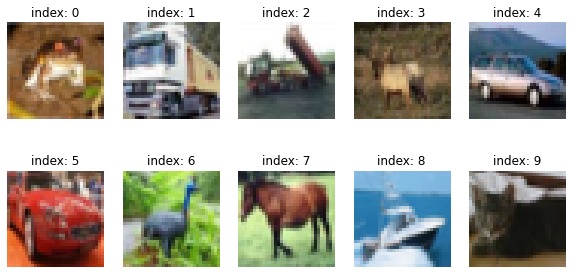

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_data[i] + 1) / 2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [4]:
# 라벨이 6번인 개구리를 이상 데이터로 가정하여 학습 데이터셋에서 제외하기

def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:            # 개구리 : 6
            new_t_labels.append([0])  # 개구리를 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [5]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [6]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []

for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [7]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [8]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [9]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [10]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [11]:
# 데이터셋이 정확하게 구성되었는지 검증

for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [14]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


### Skip-GANomaly 모델의 구현
#### Generator

In [15]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [16]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [17]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64)  # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2

        self.center = layers.Conv2D(512, 3, strides=2, padding='same', use_bias=False) # 1

        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64)  # 16

        self.output_layer = layers.Conv2DTranspose(3, 1, strides=2, padding='same',
                                                   use_bias=False, activation='tanh', # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))

    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)

        center = self.center(en_4)

        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)

        outputs = self.output_layer(de_1)

        return outputs

#### Discriminator

In [18]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64)  # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.dense_output = layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.dense_output(center)
        
        return outputs, center

In [19]:
generator = Generator()
discriminator = Discriminator()

#### Loss함수

In [20]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [21]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [22]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [23]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

### 모델의 학습과 검증

In [24]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [25]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/skip_ganomaly/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
max_epochs = 25
steps = 0
history = {'gen_loss':[], 'disc_loss':[]}

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        history['gen_loss'].append(gen_loss)
        history['disc_loss'].append(disc_loss)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Steps : 100, 	 T

Steps : 7400, 	 Total Gen Loss : 24.915870666503906, 	 Total Dis Loss : 0.012242762371897697
Steps : 7500, 	 Total Gen Loss : 22.094087600708008, 	 Total Dis Loss : 0.0013258312828838825
Steps : 7600, 	 Total Gen Loss : 22.36663818359375, 	 Total Dis Loss : 0.002020678948611021
Steps : 7700, 	 Total Gen Loss : 23.55405044555664, 	 Total Dis Loss : 0.010029375553131104
Steps : 7800, 	 Total Gen Loss : 19.693462371826172, 	 Total Dis Loss : 0.019971955567598343
Steps : 7900, 	 Total Gen Loss : 22.22916603088379, 	 Total Dis Loss : 0.007936948910355568
Steps : 8000, 	 Total Gen Loss : 19.353988647460938, 	 Total Dis Loss : 0.0022195831406861544
Steps : 8100, 	 Total Gen Loss : 24.27183723449707, 	 Total Dis Loss : 0.0013716109097003937
Steps : 8200, 	 Total Gen Loss : 20.197429656982422, 	 Total Dis Loss : 0.004856920801103115
Steps : 8300, 	 Total Gen Loss : 20.418764114379883, 	 Total Dis Loss : 0.01254365872591734
Steps : 8400, 	 Total Gen Loss : 23.41274642944336, 	 Total Dis Loss : 0

Steps : 16200, 	 Total Gen Loss : 22.627079010009766, 	 Total Dis Loss : 0.0026901483070105314
Steps : 16300, 	 Total Gen Loss : 22.428739547729492, 	 Total Dis Loss : 0.006074030417948961
Steps : 16400, 	 Total Gen Loss : 24.793712615966797, 	 Total Dis Loss : 0.001096963183954358
Steps : 16500, 	 Total Gen Loss : 26.858379364013672, 	 Total Dis Loss : 0.0003577850293368101
Steps : 16600, 	 Total Gen Loss : 24.989459991455078, 	 Total Dis Loss : 0.0007045702077448368
Steps : 16700, 	 Total Gen Loss : 25.771949768066406, 	 Total Dis Loss : 0.0006426242180168629
Steps : 16800, 	 Total Gen Loss : 26.22509002685547, 	 Total Dis Loss : 0.0012246519327163696
Time for epoch 3 is 452.5555546283722 sec
Steps : 16900, 	 Total Gen Loss : 23.806947708129883, 	 Total Dis Loss : 0.0005495796212926507
Steps : 17000, 	 Total Gen Loss : 23.963274002075195, 	 Total Dis Loss : 0.004217048175632954
Steps : 17100, 	 Total Gen Loss : 23.50937843322754, 	 Total Dis Loss : 0.0016148211434483528
Steps : 17200

Steps : 24800, 	 Total Gen Loss : 25.31634521484375, 	 Total Dis Loss : 0.0645768940448761
Steps : 24900, 	 Total Gen Loss : 23.246402740478516, 	 Total Dis Loss : 0.0018167989328503609
Steps : 25000, 	 Total Gen Loss : 22.276948928833008, 	 Total Dis Loss : 0.0008596946718171239
Steps : 25100, 	 Total Gen Loss : 22.54305648803711, 	 Total Dis Loss : 0.0022246793378144503
Steps : 25200, 	 Total Gen Loss : 22.573156356811523, 	 Total Dis Loss : 0.0006601655622944236
Steps : 25300, 	 Total Gen Loss : 18.614965438842773, 	 Total Dis Loss : 0.010564706288278103
Steps : 25400, 	 Total Gen Loss : 24.813072204589844, 	 Total Dis Loss : 0.0004921337822452188
Steps : 25500, 	 Total Gen Loss : 25.762470245361328, 	 Total Dis Loss : 0.0015874594682827592
Steps : 25600, 	 Total Gen Loss : 24.307201385498047, 	 Total Dis Loss : 0.00018233673472423106
Steps : 25700, 	 Total Gen Loss : 24.950403213500977, 	 Total Dis Loss : 0.0024540177546441555
Steps : 25800, 	 Total Gen Loss : 22.647140502929688, 	

Steps : 33500, 	 Total Gen Loss : 23.043643951416016, 	 Total Dis Loss : 0.012812428176403046
Steps : 33600, 	 Total Gen Loss : 26.726104736328125, 	 Total Dis Loss : 0.0018033692613244057
Steps : 33700, 	 Total Gen Loss : 25.663013458251953, 	 Total Dis Loss : 0.010186293162405491
Time for epoch 6 is 455.68519401550293 sec
Steps : 33800, 	 Total Gen Loss : 23.74258804321289, 	 Total Dis Loss : 0.00017407331324648112
Steps : 33900, 	 Total Gen Loss : 26.0159912109375, 	 Total Dis Loss : 0.0005127604235894978
Steps : 34000, 	 Total Gen Loss : 30.418865203857422, 	 Total Dis Loss : 0.00023284531198441982
Steps : 34100, 	 Total Gen Loss : 25.92513084411621, 	 Total Dis Loss : 0.0009946987265720963
Steps : 34200, 	 Total Gen Loss : 24.99529266357422, 	 Total Dis Loss : 0.0009160277550108731
Steps : 34300, 	 Total Gen Loss : 26.915313720703125, 	 Total Dis Loss : 0.0018994021229445934
Steps : 34400, 	 Total Gen Loss : 24.066787719726562, 	 Total Dis Loss : 0.0005737713072448969
Steps : 3450

Steps : 42100, 	 Total Gen Loss : 26.158721923828125, 	 Total Dis Loss : 0.00019080372294411063
Steps : 42200, 	 Total Gen Loss : 23.959035873413086, 	 Total Dis Loss : 0.000209193691262044
Steps : 42300, 	 Total Gen Loss : 25.50521469116211, 	 Total Dis Loss : 0.0012179049663245678
Steps : 42400, 	 Total Gen Loss : 24.77559471130371, 	 Total Dis Loss : 0.00023481047537643462
Steps : 42500, 	 Total Gen Loss : 28.09501838684082, 	 Total Dis Loss : 0.0001066308468580246
Steps : 42600, 	 Total Gen Loss : 24.144763946533203, 	 Total Dis Loss : 0.003349220147356391
Steps : 42700, 	 Total Gen Loss : 25.636568069458008, 	 Total Dis Loss : 0.0010578394867479801
Steps : 42800, 	 Total Gen Loss : 25.478885650634766, 	 Total Dis Loss : 0.07416750490665436
Steps : 42900, 	 Total Gen Loss : 23.923816680908203, 	 Total Dis Loss : 0.00023527258599642664
Steps : 43000, 	 Total Gen Loss : 26.796859741210938, 	 Total Dis Loss : 0.000929887464735657
Steps : 43100, 	 Total Gen Loss : 24.309310913085938, 	

Steps : 50700, 	 Total Gen Loss : 25.607276916503906, 	 Total Dis Loss : 0.006107000634074211
Steps : 50800, 	 Total Gen Loss : 24.300687789916992, 	 Total Dis Loss : 0.016582481563091278
Steps : 50900, 	 Total Gen Loss : 25.084814071655273, 	 Total Dis Loss : 0.0005136776017025113
Steps : 51000, 	 Total Gen Loss : 24.394550323486328, 	 Total Dis Loss : 0.0007712405640631914
Steps : 51100, 	 Total Gen Loss : 21.823698043823242, 	 Total Dis Loss : 0.0009360197000205517
Steps : 51200, 	 Total Gen Loss : 22.165267944335938, 	 Total Dis Loss : 0.0020870498847216368
Steps : 51300, 	 Total Gen Loss : 25.866851806640625, 	 Total Dis Loss : 0.0006193629815243185
Steps : 51400, 	 Total Gen Loss : 25.671585083007812, 	 Total Dis Loss : 0.001292841974645853
Steps : 51500, 	 Total Gen Loss : 24.8825740814209, 	 Total Dis Loss : 0.0005937105161137879
Steps : 51600, 	 Total Gen Loss : 26.10187339782715, 	 Total Dis Loss : 0.00032296660356223583
Steps : 51700, 	 Total Gen Loss : 29.27056884765625, 	 

Steps : 59400, 	 Total Gen Loss : 26.441762924194336, 	 Total Dis Loss : 6.462437886511907e-05
Steps : 59500, 	 Total Gen Loss : 24.924562454223633, 	 Total Dis Loss : 0.016247203573584557
Steps : 59600, 	 Total Gen Loss : 21.742847442626953, 	 Total Dis Loss : 0.00031684941495768726
Steps : 59700, 	 Total Gen Loss : 26.582717895507812, 	 Total Dis Loss : 0.0003099141758866608
Steps : 59800, 	 Total Gen Loss : 25.728429794311523, 	 Total Dis Loss : 0.00014187970373313874
Steps : 59900, 	 Total Gen Loss : 24.765472412109375, 	 Total Dis Loss : 0.0003318020608276129
Steps : 60000, 	 Total Gen Loss : 28.464698791503906, 	 Total Dis Loss : 2.0378007320687175e-05
Steps : 60100, 	 Total Gen Loss : 26.826129913330078, 	 Total Dis Loss : 1.4491700312646572e-05
Steps : 60200, 	 Total Gen Loss : 30.343929290771484, 	 Total Dis Loss : 3.0384362617041916e-05
Steps : 60300, 	 Total Gen Loss : 27.32438087463379, 	 Total Dis Loss : 4.9426438636146486e-05
Steps : 60400, 	 Total Gen Loss : 27.209360122

Steps : 68000, 	 Total Gen Loss : 27.160747528076172, 	 Total Dis Loss : 7.609401654917747e-05
Steps : 68100, 	 Total Gen Loss : 28.888219833374023, 	 Total Dis Loss : 4.4702035665977746e-05
Steps : 68200, 	 Total Gen Loss : 28.403270721435547, 	 Total Dis Loss : 0.0002741592761594802
Steps : 68300, 	 Total Gen Loss : 29.117027282714844, 	 Total Dis Loss : 0.00020009717263747007
Steps : 68400, 	 Total Gen Loss : 28.67578125, 	 Total Dis Loss : 0.0004384600615594536
Steps : 68500, 	 Total Gen Loss : 29.994491577148438, 	 Total Dis Loss : 0.0003387054312042892
Steps : 68600, 	 Total Gen Loss : 27.487903594970703, 	 Total Dis Loss : 0.0003423330490477383
Steps : 68700, 	 Total Gen Loss : 30.077861785888672, 	 Total Dis Loss : 5.696876542060636e-05
Steps : 68800, 	 Total Gen Loss : 28.85744857788086, 	 Total Dis Loss : 0.00030520150903612375
Steps : 68900, 	 Total Gen Loss : 26.719717025756836, 	 Total Dis Loss : 7.667029422009364e-05
Steps : 69000, 	 Total Gen Loss : 29.214599609375, 	 To

Steps : 76700, 	 Total Gen Loss : 27.761337280273438, 	 Total Dis Loss : 0.00022128740965854377
Steps : 76800, 	 Total Gen Loss : 29.651865005493164, 	 Total Dis Loss : 0.00023247503850143403
Steps : 76900, 	 Total Gen Loss : 27.1696834564209, 	 Total Dis Loss : 0.0003282199613749981
Steps : 77000, 	 Total Gen Loss : 28.82725715637207, 	 Total Dis Loss : 0.00010923577065113932
Steps : 77100, 	 Total Gen Loss : 25.17621612548828, 	 Total Dis Loss : 0.00019087894179392606
Steps : 77200, 	 Total Gen Loss : 26.461278915405273, 	 Total Dis Loss : 0.0007228442118503153
Steps : 77300, 	 Total Gen Loss : 23.03407859802246, 	 Total Dis Loss : 0.0002969604101963341
Steps : 77400, 	 Total Gen Loss : 30.60850715637207, 	 Total Dis Loss : 6.200425559654832e-05
Steps : 77500, 	 Total Gen Loss : 26.32000732421875, 	 Total Dis Loss : 0.0004496560140978545
Steps : 77600, 	 Total Gen Loss : 26.00446128845215, 	 Total Dis Loss : 0.012101415544748306
Steps : 77700, 	 Total Gen Loss : 27.013874053955078, 	

Steps : 85300, 	 Total Gen Loss : 25.1119441986084, 	 Total Dis Loss : 0.0002516956301406026
Steps : 85400, 	 Total Gen Loss : 27.68986701965332, 	 Total Dis Loss : 2.626077002787497e-05
Steps : 85500, 	 Total Gen Loss : 27.299894332885742, 	 Total Dis Loss : 2.5303281290689483e-05
Steps : 85600, 	 Total Gen Loss : 27.02541160583496, 	 Total Dis Loss : 3.129380274913274e-05
Steps : 85700, 	 Total Gen Loss : 28.49007225036621, 	 Total Dis Loss : 2.0919207599945366e-05
Steps : 85800, 	 Total Gen Loss : 27.35736656188965, 	 Total Dis Loss : 5.658726513502188e-05
Steps : 85900, 	 Total Gen Loss : 31.99715232849121, 	 Total Dis Loss : 0.0010565234115347266
Steps : 86000, 	 Total Gen Loss : 28.53034019470215, 	 Total Dis Loss : 2.596610465843696e-05
Steps : 86100, 	 Total Gen Loss : 27.051137924194336, 	 Total Dis Loss : 1.4808300875301939e-05
Steps : 86200, 	 Total Gen Loss : 26.783720016479492, 	 Total Dis Loss : 9.155356383416802e-05
Steps : 86300, 	 Total Gen Loss : 25.0863094329834, 	 T

Steps : 94000, 	 Total Gen Loss : 22.14916229248047, 	 Total Dis Loss : 0.0042105671018362045
Steps : 94100, 	 Total Gen Loss : 29.78545570373535, 	 Total Dis Loss : 9.207434777636081e-05
Steps : 94200, 	 Total Gen Loss : 32.67630386352539, 	 Total Dis Loss : 1.07217501863488e-05
Steps : 94300, 	 Total Gen Loss : 30.135988235473633, 	 Total Dis Loss : 0.0009985112119466066
Steps : 94400, 	 Total Gen Loss : 30.198814392089844, 	 Total Dis Loss : 0.0006856893305666745
Steps : 94500, 	 Total Gen Loss : 33.06695556640625, 	 Total Dis Loss : 0.00010798774019349366
Steps : 94600, 	 Total Gen Loss : 30.151498794555664, 	 Total Dis Loss : 0.0001110120938392356
Steps : 94700, 	 Total Gen Loss : 29.739206314086914, 	 Total Dis Loss : 0.00010752347589004785
Steps : 94800, 	 Total Gen Loss : 32.46759033203125, 	 Total Dis Loss : 2.7928017516387627e-05
Steps : 94900, 	 Total Gen Loss : 29.76749038696289, 	 Total Dis Loss : 0.0001353276165900752
Steps : 95000, 	 Total Gen Loss : 28.440515518188477, 

Steps : 102600, 	 Total Gen Loss : 26.335933685302734, 	 Total Dis Loss : 0.00040676601929590106
Steps : 102700, 	 Total Gen Loss : 27.93400764465332, 	 Total Dis Loss : 0.0004745764017570764
Steps : 102800, 	 Total Gen Loss : 26.16846466064453, 	 Total Dis Loss : 0.00023575885279569775
Steps : 102900, 	 Total Gen Loss : 27.78666877746582, 	 Total Dis Loss : 0.0002830864686984569
Steps : 103000, 	 Total Gen Loss : 25.473684310913086, 	 Total Dis Loss : 0.00020358584879431874
Steps : 103100, 	 Total Gen Loss : 25.85184097290039, 	 Total Dis Loss : 0.00015001209976617247
Steps : 103200, 	 Total Gen Loss : 26.362571716308594, 	 Total Dis Loss : 0.0002494282671250403
Steps : 103300, 	 Total Gen Loss : 26.600433349609375, 	 Total Dis Loss : 0.00040278694359585643
Steps : 103400, 	 Total Gen Loss : 23.452550888061523, 	 Total Dis Loss : 0.0002985843748319894
Steps : 103500, 	 Total Gen Loss : 25.315383911132812, 	 Total Dis Loss : 0.00023361240164376795
Steps : 103600, 	 Total Gen Loss : 27.

Steps : 111200, 	 Total Gen Loss : 24.600791931152344, 	 Total Dis Loss : 0.0006985962390899658
Steps : 111300, 	 Total Gen Loss : 27.355369567871094, 	 Total Dis Loss : 0.00018471325165592134
Steps : 111400, 	 Total Gen Loss : 26.872343063354492, 	 Total Dis Loss : 0.000147181999636814
Steps : 111500, 	 Total Gen Loss : 31.17486572265625, 	 Total Dis Loss : 6.386763561749831e-05
Steps : 111600, 	 Total Gen Loss : 26.952571868896484, 	 Total Dis Loss : 0.0007892209687270224
Steps : 111700, 	 Total Gen Loss : 23.29431915283203, 	 Total Dis Loss : 0.0009388255421072245
Steps : 111800, 	 Total Gen Loss : 26.310888290405273, 	 Total Dis Loss : 0.0004379692836664617
Steps : 111900, 	 Total Gen Loss : 27.86795997619629, 	 Total Dis Loss : 0.00013132684398442507
Steps : 112000, 	 Total Gen Loss : 26.417682647705078, 	 Total Dis Loss : 8.783462544670328e-05
Steps : 112100, 	 Total Gen Loss : 27.8779296875, 	 Total Dis Loss : 0.0001080404908861965
Steps : 112200, 	 Total Gen Loss : 26.916545867

Steps : 119700, 	 Total Gen Loss : 30.45151138305664, 	 Total Dis Loss : 7.818776066415012e-05
Steps : 119800, 	 Total Gen Loss : 30.74062728881836, 	 Total Dis Loss : 6.0245754866627976e-05
Steps : 119900, 	 Total Gen Loss : 30.227956771850586, 	 Total Dis Loss : 0.0002974596282001585
Steps : 120000, 	 Total Gen Loss : 31.230731964111328, 	 Total Dis Loss : 0.00010593562183203176
Steps : 120100, 	 Total Gen Loss : 31.840421676635742, 	 Total Dis Loss : 0.0001714920945232734
Steps : 120200, 	 Total Gen Loss : 29.518810272216797, 	 Total Dis Loss : 0.0001716136175673455
Steps : 120300, 	 Total Gen Loss : 26.878868103027344, 	 Total Dis Loss : 0.0004894373123534024
Steps : 120400, 	 Total Gen Loss : 29.084352493286133, 	 Total Dis Loss : 0.00014990242198109627
Steps : 120500, 	 Total Gen Loss : 28.792804718017578, 	 Total Dis Loss : 0.0003084569179918617
Steps : 120600, 	 Total Gen Loss : 28.684797286987305, 	 Total Dis Loss : 0.00014579560956917703
Steps : 120700, 	 Total Gen Loss : 30.

Steps : 128200, 	 Total Gen Loss : 27.702869415283203, 	 Total Dis Loss : 9.04414409887977e-05
Steps : 128300, 	 Total Gen Loss : 27.817138671875, 	 Total Dis Loss : 6.682241655653343e-05
Steps : 128400, 	 Total Gen Loss : 27.217628479003906, 	 Total Dis Loss : 4.398300006869249e-05
Steps : 128500, 	 Total Gen Loss : 24.800312042236328, 	 Total Dis Loss : 0.0001286403276026249
Steps : 128600, 	 Total Gen Loss : 28.121074676513672, 	 Total Dis Loss : 4.9688089347910136e-05
Steps : 128700, 	 Total Gen Loss : 28.31528091430664, 	 Total Dis Loss : 4.1490198782412335e-05
Steps : 128800, 	 Total Gen Loss : 26.13678550720215, 	 Total Dis Loss : 0.00018996302969753742
Steps : 128900, 	 Total Gen Loss : 26.07533073425293, 	 Total Dis Loss : 0.00024456725805066526
Steps : 129000, 	 Total Gen Loss : 31.401044845581055, 	 Total Dis Loss : 8.60402942635119e-05
Steps : 129100, 	 Total Gen Loss : 31.011978149414062, 	 Total Dis Loss : 7.24551864550449e-05
Steps : 129200, 	 Total Gen Loss : 28.3171119

Steps : 136700, 	 Total Gen Loss : 31.389869689941406, 	 Total Dis Loss : 0.0003060721210204065
Steps : 136800, 	 Total Gen Loss : 31.023963928222656, 	 Total Dis Loss : 0.00035473480238579214
Steps : 136900, 	 Total Gen Loss : 30.588369369506836, 	 Total Dis Loss : 1.6760370272095315e-05
Steps : 137000, 	 Total Gen Loss : 33.366573333740234, 	 Total Dis Loss : 8.495564543409273e-05
Steps : 137100, 	 Total Gen Loss : 32.631988525390625, 	 Total Dis Loss : 0.0003525599604472518
Steps : 137200, 	 Total Gen Loss : 32.47222900390625, 	 Total Dis Loss : 0.00011622105375863612
Steps : 137300, 	 Total Gen Loss : 30.035472869873047, 	 Total Dis Loss : 3.065311466343701e-05
Steps : 137400, 	 Total Gen Loss : 31.02224349975586, 	 Total Dis Loss : 0.00024915061658248305
Steps : 137500, 	 Total Gen Loss : 32.482398986816406, 	 Total Dis Loss : 0.00014899620146024972
Steps : 137600, 	 Total Gen Loss : 31.737733840942383, 	 Total Dis Loss : 1.6738184058340266e-05
Steps : 137700, 	 Total Gen Loss : 3

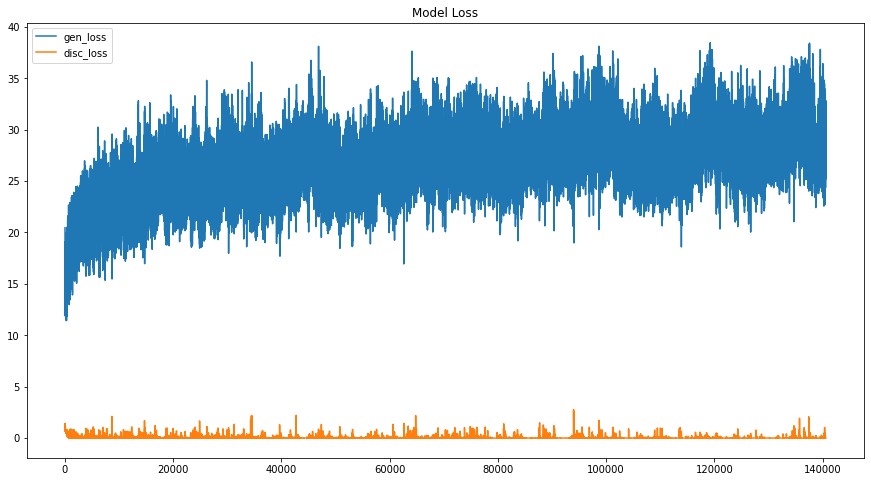

In [27]:
plt.figure(figsize=(15, 8))

plt.plot(history['gen_loss'])
plt.plot(history['disc_loss'])
plt.title('Model Loss')
plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
plt.show()

### 검증 결과의 시각화

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

#### 정상-이상 데이터의 anomaly score 분포 시각화

In [72]:
def _evaluate(test_dataset, set_lambda=0.8):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [30]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [31]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


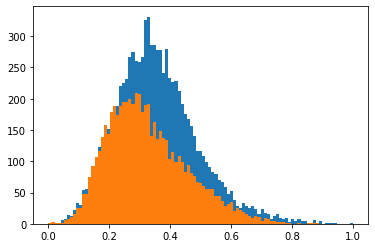

In [32]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.35633916 0.32638103
0.13497996 0.1319329


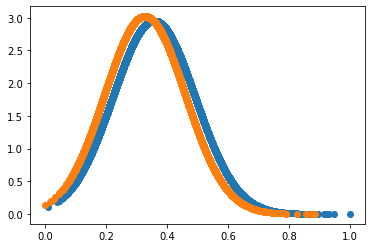

In [33]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

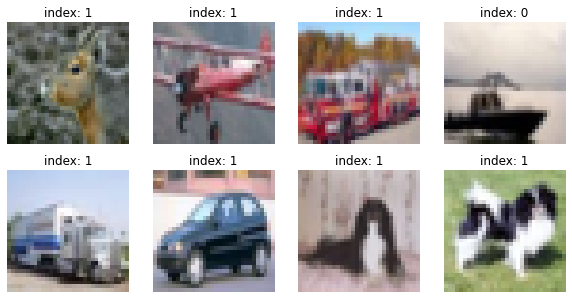

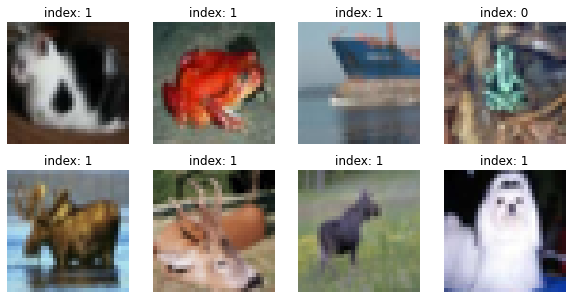

In [99]:
test1 = test_dataset.take(2)
an_scores1, gt_labels1 = _evaluate(test1)

for imgs, labels in test1:
    plt.figure(figsize=(10, 5))
    
    for i in range(len(imgs)):
        plt.subplot(2, 4, i + 1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.title(f'index: {gt_labels1[i]}')
        plt.axis('off')
    plt.show()